In [1]:
import sys
sys.path.append('/datasets/home/79/279/cs253wec/warp-ctc/lib')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import time
import copy
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim.lr_scheduler as lrs

import torchvision.utils as utils
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

from IIIT5K import IIIT5K
from warpctc_pytorch import CTCLoss

In [2]:
vgg16 = models.vgg16(pretrained=True)

In [3]:
vocab=['-']+[chr(ord('a')+i) for i in range(26)]+[chr(ord('A')+i) for i in range(26)]+[chr(ord('0')+i) for i in range(10)]
chrToindex={}
indexTochr={}
cnt=0
for c in vocab:
    chrToindex[c]=cnt
    indexTochr[cnt]=c
    cnt+=1
vocab_size=cnt # uppercase and lowercase English characters and digits(26+26+10=62)
batch_size=16
sequence_len=28
RNN_input_dim=7168
RNN_hidden_dim=256
RNN_layer=2
RNN_type='LSTM'
RNN_dropout=0
use_VGG_extractor=False
learning_rate=(4e-3)*(0.8**0)

In [4]:
num_train=2000
train_indices=range(num_train)
num_test=3000

mytransform = T.Compose(
    [
        T.Scale((224,224)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
IIIT5K_train = IIIT5K("IIIT5K-Word_V3.0", mytransform, train=True)
loader_train = DataLoader(dataset = IIIT5K_train,batch_size = batch_size, num_workers=2, 
                          sampler=SubsetRandomSampler(train_indices))

IIIT5K_test = IIIT5K("IIIT5K-Word_V3.0", mytransform, train=False)
loader_test = DataLoader(dataset = IIIT5K_test,batch_size = 1, num_workers=1, shuffle=True)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


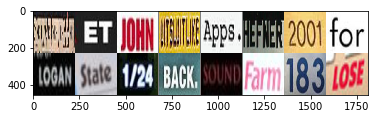

SCHWARZENEGGER ET JOHN UITSLUITLIKE Apps HEFNER 2001 for LOGAN State 124 BACK SOUND Farm 183 LOSE


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(loader_train)
images, labels = dataiter.next()

# print(images)
# print(labels)

imshow(utils.make_grid(images))
print(' '.join('%s' % labels[j] for j in range(batch_size)))

In [6]:
print('CUDA available :',torch.cuda.is_available())
cpu_dtype = torch.FloatTensor # the CPU datatype
gpu_dtype = torch.cuda.FloatTensor # the GPU datatype

dtype=gpu_dtype
print(dtype)

# From torchvision/vgg.py
def reset(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal(m.weight, gain=1)
#             n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#             m.weight.data.normal_(0, math.sqrt(2. / n))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal(m.weight, gain=1)
#             m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()
        elif hasattr(m, 'reset_parameters'):
            m.reset_parameters()
            
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

CUDA available : True
<class 'torch.cuda.FloatTensor'>


In [7]:
class CNN_block(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(CNN_block, self).__init__()
        self.conv_1=nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.conv_2=nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.conv_3=nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.batchnorm1=nn.BatchNorm2d(num_features=out_channel)
        self.batchnorm2=nn.BatchNorm2d(num_features=out_channel)
        self.batchnorm3=nn.BatchNorm2d(num_features=out_channel)
        self.relu=nn.ReLU(True)
        self.maxpool=nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        
    def forward(self, x):
        x=self.relu(self.batchnorm1(self.conv_1(x)))
        x=self.relu(self.batchnorm2(self.conv_2(x)))
        x=self.relu(self.batchnorm3(self.conv_3(x)))
        x=self.maxpool(x)
        return x
    
class ToRNN(nn.Module):
    def forward(self, x):
        x=x.permute(3,0,1,2)
        W,N,C,H= x.size()
        x.contiguous()
        return x.view(W,N,-1)
    
class BiDireRNN(nn.Module):
    def __init__(self):
        super(BiDireRNN, self).__init__()
        self.hidden_dim = RNN_hidden_dim
        self.num_layers=RNN_layer
        self.sql=sequence_len
        self.bsize=batch_size
        self.dropout=RNN_dropout
        self.rnn_type=RNN_type
        self.rnn = self.rnn_layer()
        self.hidden=None
        self.init_hidden(batch_size)
        
    def rnn_layer(self):
        if self.rnn_type=='RNN':
            return nn.RNN(RNN_input_dim, self.hidden_dim, self.num_layers, dropout=self.dropout, bidirectional=True)
        elif self.rnn_type=='LSTM':
            return nn.LSTM(RNN_input_dim, self.hidden_dim, self.num_layers, dropout=self.dropout, bidirectional=True)
        elif self.rnn_type=='GRU':
            return nn.GRU(RNN_input_dim, self.hidden_dim, self.num_layers, dropout=self.dropout, bidirectional=True)
        else:
            raise AssertionError('unknown RNN type:',self.rnn_type)
    
    def init_hidden(self,bsize):
        if self.rnn_type=='LSTM':
            self.hidden=(Variable(torch.zeros(self.num_layers*2, bsize, self.hidden_dim).type(dtype)),
                    Variable(torch.zeros(self.num_layers*2, bsize, self.hidden_dim).type(dtype)))
        else:
            self.hidden=Variable(torch.zeros(self.num_layers*2, bsize, self.hidden_dim).type(dtype))
        
    
    def forward(self, x):
        rnn_out, self.hidden = self.rnn(x, self.hidden)
        return rnn_out
        

class Model(nn.Module):
    def __init__(self,use_VGG_extractor=False):
        super(Model, self).__init__()
        if use_VGG_extractor:
            self.feature_extractor=nn.Sequential(*([vgg16.features[i] for i in range(17)]))
            for param in self.feature_extractor.parameters():
                param.requires_grad=False
                
        else:
            self.feature_extractor=nn.Sequential(*([CNN_block(3,64),CNN_block(64,128),CNN_block(128,256)]))
        self.toRNN=ToRNN()
        self.RNN=BiDireRNN()
        self.toTraget=nn.Linear(RNN_hidden_dim*2, vocab_size)
        self.softmax=nn.Softmax(dim=2)

    def forward(self, x):
        feature=self.feature_extractor(x)
        RNN_input=self.toRNN(feature)
        RNN_out=self.RNN(RNN_input)
        tag_scores = self.toTraget(RNN_out)
        return tag_scores

In [8]:
my_model=Model(use_VGG_extractor=use_VGG_extractor).type(dtype)
print(my_model)
for param in my_model.named_parameters():
    print(param[0],type(param[1].data),param[1].size(),param[1].requires_grad)

loss_function = CTCLoss().type(dtype)
# opt_parameters=my_model.parameters() if use_VGG_extractor==False else [my_model.RNN.parameters(),my_model.toTraget.parameters()]
# print(opt_parameters)
# optimizer = optim.Adam(opt_parameters, lr=4e-3)

if use_VGG_extractor:
    opt_parameters=list(my_model.RNN.parameters())+list(my_model.toTraget.parameters())
    optimizer = optim.Adam(iter(opt_parameters), lr=learning_rate)
else:
    optimizer = optim.Adam(my_model.parameters(), lr=learning_rate)

scheduler = lrs.StepLR(optimizer, step_size=20, gamma=0.8)

Model(
  (feature_extractor): Sequential(
    (0): CNN_block(
      (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    )
    (1): CNN_block(
      (conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

In [9]:
def model_train(max_epoch,print_every):

    iter_each_epoch=num_train//batch_size
    loss_his_train=[]

    for epoch in range(max_epoch):
        scheduler.step()
        my_model.train()
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
              'start epoch %d/%d:' % (epoch+1,max_epoch),'learning_rate =',scheduler.get_lr()[0],
              'sequence_len =',my_model.RNN.sql)
        tot_loss=0
        
        it=0
        for images,labels in loader_train:

            X_var=Variable(images.type(dtype))
            
            out_size=Variable(torch.IntTensor([sequence_len] * batch_size))
            y_size=Variable(torch.IntTensor([len(l) for l in labels]))
            conc_label=''.join(labels)
            y=[chrToindex[c] for c in conc_label]
            y_var=Variable(torch.IntTensor(y))

            my_model.zero_grad()

            my_model.RNN.init_hidden(batch_size)

            scores = my_model(X_var)

            loss = loss_function(scores,y_var,out_size,y_size)/batch_size
            loss.backward()
            optimizer.step()
            
            tot_loss+=loss.data[0]
            
            if it==0 or (it+1)%print_every==0 or it==iter_each_epoch-1:
                print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                      'iter %d loss = %f' % (it+1,loss.data[0]))
            it+=1
                
        tot_loss/=iter_each_epoch
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                'epoch %d/%d average_loss = %f\n' % (epoch+1,max_epoch,tot_loss))
        loss_his_train.append(tot_loss)
    return loss_his_train

In [10]:
my_model.apply(reset)
# my_model.load_state_dict(torch.load('parameters-5000'))
my_model.train()
my_model.RNN.init_hidden(batch_size)
loss_his_train=model_train(max_epoch=500,print_every=25)

2018-03-08 18:07:24 start epoch 1/500: learning_rate = 0.004 sequence_len = 28
2018-03-08 18:07:24 iter 1 loss = 96.907005
2018-03-08 18:07:28 iter 25 loss = 21.818222
2018-03-08 18:07:33 iter 50 loss = 17.193417
2018-03-08 18:07:37 iter 75 loss = 20.606865
2018-03-08 18:07:42 iter 100 loss = 18.535027
2018-03-08 18:07:46 iter 125 loss = 24.556904
2018-03-08 18:07:46 epoch 1/500 average_loss = 21.702228

2018-03-08 18:07:46 start epoch 2/500: learning_rate = 0.004 sequence_len = 28
2018-03-08 18:07:47 iter 1 loss = 26.533051
2018-03-08 18:07:51 iter 25 loss = 21.041035
2018-03-08 18:07:55 iter 50 loss = 20.461063
2018-03-08 18:08:00 iter 75 loss = 16.269157
2018-03-08 18:08:04 iter 100 loss = 21.891045
2018-03-08 18:08:09 iter 125 loss = 20.312092
2018-03-08 18:08:09 epoch 2/500 average_loss = 20.379531

2018-03-08 18:08:09 start epoch 3/500: learning_rate = 0.004 sequence_len = 28
2018-03-08 18:08:09 iter 1 loss = 18.489965
2018-03-08 18:08:13 iter 25 loss = 16.361383
2018-03-08 18:08

2018-03-08 18:14:57 iter 1 loss = 24.587269
2018-03-08 18:15:01 iter 25 loss = 20.581837
2018-03-08 18:15:06 iter 50 loss = 16.590490
2018-03-08 18:15:10 iter 75 loss = 19.278858
2018-03-08 18:15:15 iter 100 loss = 17.207766
2018-03-08 18:15:19 iter 125 loss = 18.604380
2018-03-08 18:15:19 epoch 21/500 average_loss = 18.926911

2018-03-08 18:15:19 start epoch 22/500: learning_rate = 0.0032 sequence_len = 28
2018-03-08 18:15:19 iter 1 loss = 17.395548
2018-03-08 18:15:24 iter 25 loss = 17.345572
2018-03-08 18:15:28 iter 50 loss = 15.964894
2018-03-08 18:15:33 iter 75 loss = 16.813143
2018-03-08 18:15:37 iter 100 loss = 19.638184
2018-03-08 18:15:42 iter 125 loss = 17.057049
2018-03-08 18:15:42 epoch 22/500 average_loss = 18.940365

2018-03-08 18:15:42 start epoch 23/500: learning_rate = 0.0032 sequence_len = 28
2018-03-08 18:15:42 iter 1 loss = 17.887699
2018-03-08 18:15:46 iter 25 loss = 19.762991
2018-03-08 18:15:51 iter 50 loss = 21.095530
2018-03-08 18:15:55 iter 75 loss = 19.271828

2018-03-08 18:22:30 iter 1 loss = 15.625856
2018-03-08 18:22:35 iter 25 loss = 15.109112
2018-03-08 18:22:39 iter 50 loss = 16.681295
2018-03-08 18:22:44 iter 75 loss = 19.291393
2018-03-08 18:22:48 iter 100 loss = 16.795168
2018-03-08 18:22:53 iter 125 loss = 19.505007
2018-03-08 18:22:53 epoch 41/500 average_loss = 18.496672

2018-03-08 18:22:53 start epoch 42/500: learning_rate = 0.0025600000000000006 sequence_len = 28
2018-03-08 18:22:53 iter 1 loss = 15.521307
2018-03-08 18:22:57 iter 25 loss = 22.728134
2018-03-08 18:23:02 iter 50 loss = 18.106243
2018-03-08 18:23:06 iter 75 loss = 13.986211
2018-03-08 18:23:11 iter 100 loss = 21.710064
2018-03-08 18:23:15 iter 125 loss = 21.373131
2018-03-08 18:23:15 epoch 42/500 average_loss = 18.509217

2018-03-08 18:23:15 start epoch 43/500: learning_rate = 0.0025600000000000006 sequence_len = 28
2018-03-08 18:23:16 iter 1 loss = 20.456905
2018-03-08 18:23:20 iter 25 loss = 19.325586
2018-03-08 18:23:25 iter 50 loss = 16.135363
2018-03-08 18:

2018-03-08 18:29:55 iter 75 loss = 19.950865
2018-03-08 18:30:00 iter 100 loss = 18.064140
2018-03-08 18:30:04 iter 125 loss = 17.096516
2018-03-08 18:30:04 epoch 60/500 average_loss = 18.067366

2018-03-08 18:30:04 start epoch 61/500: learning_rate = 0.0020480000000000003 sequence_len = 28
2018-03-08 18:30:05 iter 1 loss = 19.352037
2018-03-08 18:30:09 iter 25 loss = 20.288351
2018-03-08 18:30:14 iter 50 loss = 16.009926
2018-03-08 18:30:18 iter 75 loss = 15.982824
2018-03-08 18:30:23 iter 100 loss = 21.429686
2018-03-08 18:30:27 iter 125 loss = 17.947668
2018-03-08 18:30:27 epoch 61/500 average_loss = 17.944531

2018-03-08 18:30:27 start epoch 62/500: learning_rate = 0.0020480000000000003 sequence_len = 28
2018-03-08 18:30:28 iter 1 loss = 16.156906
2018-03-08 18:30:32 iter 25 loss = 17.113073
2018-03-08 18:30:36 iter 50 loss = 18.036512
2018-03-08 18:30:41 iter 75 loss = 19.500742
2018-03-08 18:30:46 iter 100 loss = 16.956022
2018-03-08 18:30:50 iter 125 loss = 16.235659
2018-03-08 

2018-03-08 18:37:16 iter 1 loss = 19.891037
2018-03-08 18:37:21 iter 25 loss = 16.929680
2018-03-08 18:37:25 iter 50 loss = 17.207699
2018-03-08 18:37:30 iter 75 loss = 18.118616
2018-03-08 18:37:34 iter 100 loss = 15.915450
2018-03-08 18:37:39 iter 125 loss = 17.007378
2018-03-08 18:37:39 epoch 80/500 average_loss = 17.393114

2018-03-08 18:37:39 start epoch 81/500: learning_rate = 0.0016384000000000004 sequence_len = 28
2018-03-08 18:37:39 iter 1 loss = 16.175760
2018-03-08 18:37:43 iter 25 loss = 17.064770
2018-03-08 18:37:48 iter 50 loss = 21.259529
2018-03-08 18:37:52 iter 75 loss = 12.720884
2018-03-08 18:37:57 iter 100 loss = 15.915300
2018-03-08 18:38:01 iter 125 loss = 20.905464
2018-03-08 18:38:01 epoch 81/500 average_loss = 17.283384

2018-03-08 18:38:01 start epoch 82/500: learning_rate = 0.0016384000000000004 sequence_len = 28
2018-03-08 18:38:02 iter 1 loss = 16.427465
2018-03-08 18:38:06 iter 25 loss = 15.067273
2018-03-08 18:38:11 iter 50 loss = 18.112923
2018-03-08 18:

2018-03-08 18:44:41 iter 75 loss = 14.731535
2018-03-08 18:44:45 iter 100 loss = 16.895464
2018-03-08 18:44:50 iter 125 loss = 13.824854
2018-03-08 18:44:50 epoch 99/500 average_loss = 16.610356

2018-03-08 18:44:50 start epoch 100/500: learning_rate = 0.0016384000000000004 sequence_len = 28
2018-03-08 18:44:50 iter 1 loss = 17.966244
2018-03-08 18:44:54 iter 25 loss = 19.138031
2018-03-08 18:44:59 iter 50 loss = 16.553051
2018-03-08 18:45:03 iter 75 loss = 17.120121
2018-03-08 18:45:08 iter 100 loss = 12.430461
2018-03-08 18:45:12 iter 125 loss = 16.779318
2018-03-08 18:45:12 epoch 100/500 average_loss = 16.526167

2018-03-08 18:45:12 start epoch 101/500: learning_rate = 0.0013107200000000005 sequence_len = 28
2018-03-08 18:45:13 iter 1 loss = 18.338894
2018-03-08 18:45:17 iter 25 loss = 12.885703
2018-03-08 18:45:22 iter 50 loss = 15.078614
2018-03-08 18:45:26 iter 75 loss = 17.904293
2018-03-08 18:45:31 iter 100 loss = 18.805298
2018-03-08 18:45:35 iter 125 loss = 16.691442
2018-03-

2018-03-08 18:52:01 iter 125 loss = 18.469246
2018-03-08 18:52:01 epoch 118/500 average_loss = 15.295913

2018-03-08 18:52:01 start epoch 119/500: learning_rate = 0.0013107200000000005 sequence_len = 28
2018-03-08 18:52:01 iter 1 loss = 20.092548
2018-03-08 18:52:05 iter 25 loss = 13.516948
2018-03-08 18:52:10 iter 50 loss = 11.155045
2018-03-08 18:52:14 iter 75 loss = 15.356452
2018-03-08 18:52:19 iter 100 loss = 14.319657
2018-03-08 18:52:24 iter 125 loss = 14.297576
2018-03-08 18:52:24 epoch 119/500 average_loss = 15.471528

2018-03-08 18:52:24 start epoch 120/500: learning_rate = 0.0013107200000000005 sequence_len = 28
2018-03-08 18:52:24 iter 1 loss = 17.668957
2018-03-08 18:52:28 iter 25 loss = 15.005078
2018-03-08 18:52:33 iter 50 loss = 16.960142
2018-03-08 18:52:37 iter 75 loss = 20.358866
2018-03-08 18:52:42 iter 100 loss = 18.008684
2018-03-08 18:52:46 iter 125 loss = 16.865803
2018-03-08 18:52:46 epoch 120/500 average_loss = 15.126138

2018-03-08 18:52:46 start epoch 121/50

2018-03-08 18:59:12 iter 1 loss = 11.231375
2018-03-08 18:59:17 iter 25 loss = 15.281316
2018-03-08 18:59:21 iter 50 loss = 14.632611
2018-03-08 18:59:26 iter 75 loss = 13.381388
2018-03-08 18:59:30 iter 100 loss = 11.504315
2018-03-08 18:59:35 iter 125 loss = 15.113343
2018-03-08 18:59:35 epoch 138/500 average_loss = 13.195222

2018-03-08 18:59:35 start epoch 139/500: learning_rate = 0.0010485760000000005 sequence_len = 28
2018-03-08 18:59:35 iter 1 loss = 10.345231
2018-03-08 18:59:39 iter 25 loss = 11.036860
2018-03-08 18:59:44 iter 50 loss = 10.970812
2018-03-08 18:59:48 iter 75 loss = 15.847956
2018-03-08 18:59:53 iter 100 loss = 14.021117
2018-03-08 18:59:57 iter 125 loss = 16.726204
2018-03-08 18:59:57 epoch 139/500 average_loss = 13.039515

2018-03-08 18:59:57 start epoch 140/500: learning_rate = 0.0010485760000000005 sequence_len = 28
2018-03-08 18:59:58 iter 1 loss = 10.594344
2018-03-08 19:00:02 iter 25 loss = 14.409817
2018-03-08 19:00:06 iter 50 loss = 13.717185
2018-03-08

2018-03-08 19:06:32 iter 50 loss = 10.029941
2018-03-08 19:06:37 iter 75 loss = 9.793942
2018-03-08 19:06:41 iter 100 loss = 9.142332
2018-03-08 19:06:46 iter 125 loss = 10.405263
2018-03-08 19:06:46 epoch 157/500 average_loss = 10.179849

2018-03-08 19:06:46 start epoch 158/500: learning_rate = 0.0008388608000000004 sequence_len = 28
2018-03-08 19:06:46 iter 1 loss = 11.479281
2018-03-08 19:06:51 iter 25 loss = 9.174651
2018-03-08 19:06:55 iter 50 loss = 9.746034
2018-03-08 19:07:00 iter 75 loss = 10.749884
2018-03-08 19:07:04 iter 100 loss = 10.758852
2018-03-08 19:07:09 iter 125 loss = 9.643299
2018-03-08 19:07:09 epoch 158/500 average_loss = 9.927921

2018-03-08 19:07:09 start epoch 159/500: learning_rate = 0.0008388608000000004 sequence_len = 28
2018-03-08 19:07:09 iter 1 loss = 14.576803
2018-03-08 19:07:13 iter 25 loss = 10.827083
2018-03-08 19:07:18 iter 50 loss = 9.523973
2018-03-08 19:07:22 iter 75 loss = 9.236382
2018-03-08 19:07:27 iter 100 loss = 10.723438
2018-03-08 19:07

2018-03-08 19:13:57 iter 1 loss = 7.793108
2018-03-08 19:14:02 iter 25 loss = 5.655772
2018-03-08 19:14:06 iter 50 loss = 4.622310
2018-03-08 19:14:11 iter 75 loss = 6.701264
2018-03-08 19:14:15 iter 100 loss = 6.951792
2018-03-08 19:14:20 iter 125 loss = 6.725945
2018-03-08 19:14:20 epoch 177/500 average_loss = 5.998217

2018-03-08 19:14:20 start epoch 178/500: learning_rate = 0.0006710886400000004 sequence_len = 28
2018-03-08 19:14:20 iter 1 loss = 6.182891
2018-03-08 19:14:24 iter 25 loss = 2.616933
2018-03-08 19:14:29 iter 50 loss = 6.531046
2018-03-08 19:14:33 iter 75 loss = 6.112081
2018-03-08 19:14:38 iter 100 loss = 3.843343
2018-03-08 19:14:42 iter 125 loss = 5.515803
2018-03-08 19:14:42 epoch 178/500 average_loss = 5.783387

2018-03-08 19:14:42 start epoch 179/500: learning_rate = 0.0006710886400000004 sequence_len = 28
2018-03-08 19:14:43 iter 1 loss = 5.125729
2018-03-08 19:14:47 iter 25 loss = 4.815613
2018-03-08 19:14:51 iter 50 loss = 4.685357
2018-03-08 19:14:56 iter 75

2018-03-08 19:21:31 iter 125 loss = 3.180977
2018-03-08 19:21:31 epoch 196/500 average_loss = 2.356845

2018-03-08 19:21:31 start epoch 197/500: learning_rate = 0.0005368709120000003 sequence_len = 28
2018-03-08 19:21:31 iter 1 loss = 5.700984
2018-03-08 19:21:36 iter 25 loss = 2.145600
2018-03-08 19:21:40 iter 50 loss = 1.694910
2018-03-08 19:21:45 iter 75 loss = 2.620368
2018-03-08 19:21:49 iter 100 loss = 3.351726
2018-03-08 19:21:54 iter 125 loss = 3.434710
2018-03-08 19:21:54 epoch 197/500 average_loss = 2.197913

2018-03-08 19:21:54 start epoch 198/500: learning_rate = 0.0005368709120000003 sequence_len = 28
2018-03-08 19:21:54 iter 1 loss = 1.985741
2018-03-08 19:21:58 iter 25 loss = 1.865352
2018-03-08 19:22:03 iter 50 loss = 1.513009
2018-03-08 19:22:07 iter 75 loss = 2.907713
2018-03-08 19:22:12 iter 100 loss = 2.995685
2018-03-08 19:22:16 iter 125 loss = 2.453768
2018-03-08 19:22:16 epoch 198/500 average_loss = 2.112842

2018-03-08 19:22:16 start epoch 199/500: learning_rate

2018-03-08 19:28:43 iter 1 loss = 0.550167
2018-03-08 19:28:48 iter 25 loss = 0.222489
2018-03-08 19:28:52 iter 50 loss = 0.421047
2018-03-08 19:28:57 iter 75 loss = 0.578653
2018-03-08 19:29:01 iter 100 loss = 0.846488
2018-03-08 19:29:06 iter 125 loss = 0.436231
2018-03-08 19:29:06 epoch 216/500 average_loss = 0.549850

2018-03-08 19:29:06 start epoch 217/500: learning_rate = 0.00042949672960000023 sequence_len = 28
2018-03-08 19:29:06 iter 1 loss = 0.604457
2018-03-08 19:29:11 iter 25 loss = 0.725416
2018-03-08 19:29:15 iter 50 loss = 0.420610
2018-03-08 19:29:20 iter 75 loss = 0.281889
2018-03-08 19:29:24 iter 100 loss = 0.466504
2018-03-08 19:29:29 iter 125 loss = 0.449882
2018-03-08 19:29:29 epoch 217/500 average_loss = 0.525071

2018-03-08 19:29:29 start epoch 218/500: learning_rate = 0.00042949672960000023 sequence_len = 28
2018-03-08 19:29:29 iter 1 loss = 0.302497
2018-03-08 19:29:33 iter 25 loss = 0.289472
2018-03-08 19:29:38 iter 50 loss = 0.187576
2018-03-08 19:29:42 iter 

2018-03-08 19:36:18 iter 125 loss = 0.167864
2018-03-08 19:36:18 epoch 235/500 average_loss = 0.145418

2018-03-08 19:36:18 start epoch 236/500: learning_rate = 0.0003435973836800002 sequence_len = 28
2018-03-08 19:36:18 iter 1 loss = 0.082236
2018-03-08 19:36:23 iter 25 loss = 0.109802
2018-03-08 19:36:27 iter 50 loss = 0.124496
2018-03-08 19:36:32 iter 75 loss = 0.106869
2018-03-08 19:36:36 iter 100 loss = 0.300802
2018-03-08 19:36:41 iter 125 loss = 0.184149
2018-03-08 19:36:41 epoch 236/500 average_loss = 0.134681

2018-03-08 19:36:41 start epoch 237/500: learning_rate = 0.0003435973836800002 sequence_len = 28
2018-03-08 19:36:41 iter 1 loss = 0.192444
2018-03-08 19:36:45 iter 25 loss = 0.144613
2018-03-08 19:36:50 iter 50 loss = 0.150772
2018-03-08 19:36:54 iter 75 loss = 0.099522
2018-03-08 19:36:59 iter 100 loss = 0.092707
2018-03-08 19:37:03 iter 125 loss = 0.179607
2018-03-08 19:37:03 epoch 237/500 average_loss = 0.153448

2018-03-08 19:37:03 start epoch 238/500: learning_rate

2018-03-08 19:43:30 iter 1 loss = 0.039610
2018-03-08 19:43:35 iter 25 loss = 0.051189
2018-03-08 19:43:39 iter 50 loss = 0.069305
2018-03-08 19:43:44 iter 75 loss = 0.103551
2018-03-08 19:43:48 iter 100 loss = 0.039686
2018-03-08 19:43:53 iter 125 loss = 0.044627
2018-03-08 19:43:53 epoch 255/500 average_loss = 0.088002

2018-03-08 19:43:53 start epoch 256/500: learning_rate = 0.0002748779069440002 sequence_len = 28
2018-03-08 19:43:53 iter 1 loss = 0.045157
2018-03-08 19:43:57 iter 25 loss = 0.081444
2018-03-08 19:44:02 iter 50 loss = 0.072783
2018-03-08 19:44:07 iter 75 loss = 0.074171
2018-03-08 19:44:11 iter 100 loss = 0.143444
2018-03-08 19:44:16 iter 125 loss = 0.251890
2018-03-08 19:44:16 epoch 256/500 average_loss = 0.139029

2018-03-08 19:44:16 start epoch 257/500: learning_rate = 0.0002748779069440002 sequence_len = 28
2018-03-08 19:44:16 iter 1 loss = 0.265878
2018-03-08 19:44:20 iter 25 loss = 0.214135
2018-03-08 19:44:25 iter 50 loss = 0.297457
2018-03-08 19:44:29 iter 75

2018-03-08 19:51:05 iter 125 loss = 0.020297
2018-03-08 19:51:05 epoch 274/500 average_loss = 0.025111

2018-03-08 19:51:05 start epoch 275/500: learning_rate = 0.00021990232555520016 sequence_len = 28
2018-03-08 19:51:05 iter 1 loss = 0.016225
2018-03-08 19:51:10 iter 25 loss = 0.025045
2018-03-08 19:51:14 iter 50 loss = 0.016285
2018-03-08 19:51:19 iter 75 loss = 0.027120
2018-03-08 19:51:23 iter 100 loss = 0.037162
2018-03-08 19:51:28 iter 125 loss = 0.196588
2018-03-08 19:51:28 epoch 275/500 average_loss = 0.026586

2018-03-08 19:51:28 start epoch 276/500: learning_rate = 0.00021990232555520016 sequence_len = 28
2018-03-08 19:51:28 iter 1 loss = 0.040843
2018-03-08 19:51:33 iter 25 loss = 0.033732
2018-03-08 19:51:37 iter 50 loss = 0.022323
2018-03-08 19:51:42 iter 75 loss = 0.034014
2018-03-08 19:51:46 iter 100 loss = 0.035158
2018-03-08 19:51:51 iter 125 loss = 0.025370
2018-03-08 19:51:51 epoch 276/500 average_loss = 0.034182

2018-03-08 19:51:51 start epoch 277/500: learning_ra

2018-03-08 19:58:18 iter 1 loss = 0.017834
2018-03-08 19:58:22 iter 25 loss = 0.017218
2018-03-08 19:58:27 iter 50 loss = 0.057931
2018-03-08 19:58:32 iter 75 loss = 0.021942
2018-03-08 19:58:36 iter 100 loss = 0.011090
2018-03-08 19:58:41 iter 125 loss = 0.030688
2018-03-08 19:58:41 epoch 294/500 average_loss = 0.017837

2018-03-08 19:58:41 start epoch 295/500: learning_rate = 0.00017592186044416015 sequence_len = 28
2018-03-08 19:58:41 iter 1 loss = 0.020189
2018-03-08 19:58:45 iter 25 loss = 0.028897
2018-03-08 19:58:50 iter 50 loss = 0.045979
2018-03-08 19:58:54 iter 75 loss = 0.010197
2018-03-08 19:58:59 iter 100 loss = 0.018213
2018-03-08 19:59:03 iter 125 loss = 0.017357
2018-03-08 19:59:03 epoch 295/500 average_loss = 0.016896

2018-03-08 19:59:03 start epoch 296/500: learning_rate = 0.00017592186044416015 sequence_len = 28
2018-03-08 19:59:04 iter 1 loss = 0.012293
2018-03-08 19:59:08 iter 25 loss = 0.011786
2018-03-08 19:59:13 iter 50 loss = 0.023475
2018-03-08 19:59:17 iter 

2018-03-08 20:05:48 iter 100 loss = 0.009607
2018-03-08 20:05:53 iter 125 loss = 0.006148
2018-03-08 20:05:53 epoch 313/500 average_loss = 0.011748

2018-03-08 20:05:53 start epoch 314/500: learning_rate = 0.00014073748835532812 sequence_len = 28
2018-03-08 20:05:53 iter 1 loss = 0.011671
2018-03-08 20:05:58 iter 25 loss = 0.328471
2018-03-08 20:06:02 iter 50 loss = 0.021535
2018-03-08 20:06:07 iter 75 loss = 0.056941
2018-03-08 20:06:11 iter 100 loss = 0.042500
2018-03-08 20:06:16 iter 125 loss = 0.041648
2018-03-08 20:06:16 epoch 314/500 average_loss = 0.061924

2018-03-08 20:06:16 start epoch 315/500: learning_rate = 0.00014073748835532812 sequence_len = 28
2018-03-08 20:06:16 iter 1 loss = 0.015977
2018-03-08 20:06:20 iter 25 loss = 0.020658
2018-03-08 20:06:25 iter 50 loss = 0.013536
2018-03-08 20:06:29 iter 75 loss = 0.010431
2018-03-08 20:06:34 iter 100 loss = 0.086350
2018-03-08 20:06:38 iter 125 loss = 0.022189
2018-03-08 20:06:38 epoch 315/500 average_loss = 0.025222

2018-03

2018-03-08 20:13:04 iter 1 loss = 0.003044
2018-03-08 20:13:08 iter 25 loss = 0.006088
2018-03-08 20:13:13 iter 50 loss = 0.037467
2018-03-08 20:13:17 iter 75 loss = 0.004016
2018-03-08 20:13:22 iter 100 loss = 0.006526
2018-03-08 20:13:26 iter 125 loss = 0.004521
2018-03-08 20:13:26 epoch 333/500 average_loss = 0.006448

2018-03-08 20:13:26 start epoch 334/500: learning_rate = 0.00011258999068426249 sequence_len = 28
2018-03-08 20:13:27 iter 1 loss = 0.006500
2018-03-08 20:13:31 iter 25 loss = 0.006601
2018-03-08 20:13:36 iter 50 loss = 0.005868
2018-03-08 20:13:40 iter 75 loss = 0.008147
2018-03-08 20:13:45 iter 100 loss = 0.006668
2018-03-08 20:13:49 iter 125 loss = 0.021702
2018-03-08 20:13:49 epoch 334/500 average_loss = 0.010158

2018-03-08 20:13:49 start epoch 335/500: learning_rate = 0.00011258999068426249 sequence_len = 28
2018-03-08 20:13:49 iter 1 loss = 0.028030
2018-03-08 20:13:54 iter 25 loss = 0.008470
2018-03-08 20:13:58 iter 50 loss = 0.004046
2018-03-08 20:14:03 iter 

2018-03-08 20:20:38 iter 125 loss = 0.002133
2018-03-08 20:20:38 epoch 352/500 average_loss = 0.004388

2018-03-08 20:20:38 start epoch 353/500: learning_rate = 9.007199254741001e-05 sequence_len = 28
2018-03-08 20:20:38 iter 1 loss = 0.003269
2018-03-08 20:20:43 iter 25 loss = 0.008979
2018-03-08 20:20:47 iter 50 loss = 0.002510
2018-03-08 20:20:52 iter 75 loss = 0.002293
2018-03-08 20:20:56 iter 100 loss = 0.002544
2018-03-08 20:21:01 iter 125 loss = 0.008478
2018-03-08 20:21:01 epoch 353/500 average_loss = 0.004362

2018-03-08 20:21:01 start epoch 354/500: learning_rate = 9.007199254741001e-05 sequence_len = 28
2018-03-08 20:21:01 iter 1 loss = 0.008926
2018-03-08 20:21:05 iter 25 loss = 0.003687
2018-03-08 20:21:10 iter 50 loss = 0.001881
2018-03-08 20:21:14 iter 75 loss = 0.006560
2018-03-08 20:21:19 iter 100 loss = 0.011896
2018-03-08 20:21:23 iter 125 loss = 0.008005
2018-03-08 20:21:23 epoch 354/500 average_loss = 0.005982

2018-03-08 20:21:23 start epoch 355/500: learning_rate

2018-03-08 20:27:50 iter 1 loss = 0.003373
2018-03-08 20:27:54 iter 25 loss = 0.001732
2018-03-08 20:27:59 iter 50 loss = 0.002192
2018-03-08 20:28:03 iter 75 loss = 0.004146
2018-03-08 20:28:08 iter 100 loss = 0.001867
2018-03-08 20:28:12 iter 125 loss = 0.001204
2018-03-08 20:28:12 epoch 372/500 average_loss = 0.002927

2018-03-08 20:28:12 start epoch 373/500: learning_rate = 7.205759403792801e-05 sequence_len = 28
2018-03-08 20:28:13 iter 1 loss = 0.001705
2018-03-08 20:28:17 iter 25 loss = 0.003186
2018-03-08 20:28:21 iter 50 loss = 0.002871
2018-03-08 20:28:26 iter 75 loss = 0.002834
2018-03-08 20:28:30 iter 100 loss = 0.002887
2018-03-08 20:28:35 iter 125 loss = 0.001812
2018-03-08 20:28:35 epoch 373/500 average_loss = 0.003356

2018-03-08 20:28:35 start epoch 374/500: learning_rate = 7.205759403792801e-05 sequence_len = 28
2018-03-08 20:28:35 iter 1 loss = 0.004465
2018-03-08 20:28:40 iter 25 loss = 0.002483
2018-03-08 20:28:44 iter 50 loss = 0.001778
2018-03-08 20:28:49 iter 75

2018-03-08 20:35:24 iter 125 loss = 0.001775
2018-03-08 20:35:24 epoch 391/500 average_loss = 0.003145

2018-03-08 20:35:24 start epoch 392/500: learning_rate = 5.764607523034241e-05 sequence_len = 28
2018-03-08 20:35:24 iter 1 loss = 0.001467
2018-03-08 20:35:29 iter 25 loss = 0.002521
2018-03-08 20:35:33 iter 50 loss = 0.004220
2018-03-08 20:35:38 iter 75 loss = 0.007090
2018-03-08 20:35:42 iter 100 loss = 0.001825
2018-03-08 20:35:47 iter 125 loss = 0.003012
2018-03-08 20:35:47 epoch 392/500 average_loss = 0.002757

2018-03-08 20:35:47 start epoch 393/500: learning_rate = 5.764607523034241e-05 sequence_len = 28
2018-03-08 20:35:47 iter 1 loss = 0.001727
2018-03-08 20:35:52 iter 25 loss = 0.001159
2018-03-08 20:35:56 iter 50 loss = 0.001986
2018-03-08 20:36:01 iter 75 loss = 0.001484
2018-03-08 20:36:05 iter 100 loss = 0.002201
2018-03-08 20:36:10 iter 125 loss = 0.003030
2018-03-08 20:36:10 epoch 393/500 average_loss = 0.002540

2018-03-08 20:36:10 start epoch 394/500: learning_rate

2018-03-08 20:42:36 iter 1 loss = 0.001228
2018-03-08 20:42:40 iter 25 loss = 0.001154
2018-03-08 20:42:45 iter 50 loss = 0.001159
2018-03-08 20:42:49 iter 75 loss = 0.002827
2018-03-08 20:42:54 iter 100 loss = 0.001127
2018-03-08 20:42:58 iter 125 loss = 0.001652
2018-03-08 20:42:58 epoch 411/500 average_loss = 0.001938

2018-03-08 20:42:58 start epoch 412/500: learning_rate = 4.611686018427393e-05 sequence_len = 28
2018-03-08 20:42:59 iter 1 loss = 0.001611
2018-03-08 20:43:03 iter 25 loss = 0.002992
2018-03-08 20:43:08 iter 50 loss = 0.005393
2018-03-08 20:43:12 iter 75 loss = 0.002296
2018-03-08 20:43:17 iter 100 loss = 0.001876
2018-03-08 20:43:21 iter 125 loss = 0.001235
2018-03-08 20:43:21 epoch 412/500 average_loss = 0.001913

2018-03-08 20:43:21 start epoch 413/500: learning_rate = 4.611686018427393e-05 sequence_len = 28
2018-03-08 20:43:21 iter 1 loss = 0.001433
2018-03-08 20:43:26 iter 25 loss = 0.001778
2018-03-08 20:43:30 iter 50 loss = 0.001623
2018-03-08 20:43:35 iter 75

2018-03-08 20:50:10 iter 125 loss = 0.001243
2018-03-08 20:50:10 epoch 430/500 average_loss = 0.002085

2018-03-08 20:50:10 start epoch 431/500: learning_rate = 3.689348814741915e-05 sequence_len = 28
2018-03-08 20:50:10 iter 1 loss = 0.001205
2018-03-08 20:50:15 iter 25 loss = 0.000926
2018-03-08 20:50:19 iter 50 loss = 0.003727
2018-03-08 20:50:24 iter 75 loss = 0.002337
2018-03-08 20:50:28 iter 100 loss = 0.001439
2018-03-08 20:50:33 iter 125 loss = 0.001429
2018-03-08 20:50:33 epoch 431/500 average_loss = 0.002038

2018-03-08 20:50:33 start epoch 432/500: learning_rate = 3.689348814741915e-05 sequence_len = 28
2018-03-08 20:50:33 iter 1 loss = 0.001744
2018-03-08 20:50:37 iter 25 loss = 0.004427
2018-03-08 20:50:42 iter 50 loss = 0.001906
2018-03-08 20:50:46 iter 75 loss = 0.001447
2018-03-08 20:50:51 iter 100 loss = 0.001472
2018-03-08 20:50:55 iter 125 loss = 0.001054
2018-03-08 20:50:55 epoch 432/500 average_loss = 0.002284

2018-03-08 20:50:55 start epoch 433/500: learning_rate

2018-03-08 20:57:22 iter 1 loss = 0.001930
2018-03-08 20:57:26 iter 25 loss = 0.001103
2018-03-08 20:57:30 iter 50 loss = 0.003131
2018-03-08 20:57:35 iter 75 loss = 0.001611
2018-03-08 20:57:39 iter 100 loss = 0.001199
2018-03-08 20:57:44 iter 125 loss = 0.001385
2018-03-08 20:57:44 epoch 450/500 average_loss = 0.001591

2018-03-08 20:57:44 start epoch 451/500: learning_rate = 2.951479051793532e-05 sequence_len = 28
2018-03-08 20:57:44 iter 1 loss = 0.001148
2018-03-08 20:57:49 iter 25 loss = 0.001140
2018-03-08 20:57:53 iter 50 loss = 0.001903
2018-03-08 20:57:58 iter 75 loss = 0.002406
2018-03-08 20:58:02 iter 100 loss = 0.001375
2018-03-08 20:58:07 iter 125 loss = 0.002684
2018-03-08 20:58:07 epoch 451/500 average_loss = 0.004318

2018-03-08 20:58:07 start epoch 452/500: learning_rate = 2.951479051793532e-05 sequence_len = 28
2018-03-08 20:58:07 iter 1 loss = 0.002467
2018-03-08 20:58:11 iter 25 loss = 0.002094
2018-03-08 20:58:16 iter 50 loss = 0.004822
2018-03-08 20:58:20 iter 75

2018-03-08 21:04:56 iter 125 loss = 0.001437
2018-03-08 21:04:56 epoch 469/500 average_loss = 0.001155

2018-03-08 21:04:56 start epoch 470/500: learning_rate = 2.3611832414348257e-05 sequence_len = 28
2018-03-08 21:04:56 iter 1 loss = 0.001383
2018-03-08 21:05:01 iter 25 loss = 0.001218
2018-03-08 21:05:05 iter 50 loss = 0.003694
2018-03-08 21:05:10 iter 75 loss = 0.000770
2018-03-08 21:05:14 iter 100 loss = 0.000884
2018-03-08 21:05:19 iter 125 loss = 0.003808
2018-03-08 21:05:19 epoch 470/500 average_loss = 0.002110

2018-03-08 21:05:19 start epoch 471/500: learning_rate = 2.3611832414348257e-05 sequence_len = 28
2018-03-08 21:05:19 iter 1 loss = 0.000933
2018-03-08 21:05:23 iter 25 loss = 0.001976
2018-03-08 21:05:28 iter 50 loss = 0.000917
2018-03-08 21:05:33 iter 75 loss = 0.000881
2018-03-08 21:05:37 iter 100 loss = 0.001107
2018-03-08 21:05:42 iter 125 loss = 0.000800
2018-03-08 21:05:42 epoch 471/500 average_loss = 0.001211

2018-03-08 21:05:42 start epoch 472/500: learning_ra

2018-03-08 21:12:09 iter 1 loss = 0.000862
2018-03-08 21:12:13 iter 25 loss = 0.000742
2018-03-08 21:12:18 iter 50 loss = 0.000874
2018-03-08 21:12:22 iter 75 loss = 0.000842
2018-03-08 21:12:27 iter 100 loss = 0.001200
2018-03-08 21:12:31 iter 125 loss = 0.000842
2018-03-08 21:12:31 epoch 489/500 average_loss = 0.001330

2018-03-08 21:12:31 start epoch 490/500: learning_rate = 1.888946593147861e-05 sequence_len = 28
2018-03-08 21:12:32 iter 1 loss = 0.001670
2018-03-08 21:12:36 iter 25 loss = 0.000963
2018-03-08 21:12:40 iter 50 loss = 0.000924
2018-03-08 21:12:45 iter 75 loss = 0.000760
2018-03-08 21:12:49 iter 100 loss = 0.000698
2018-03-08 21:12:54 iter 125 loss = 0.000662
2018-03-08 21:12:54 epoch 490/500 average_loss = 0.001343

2018-03-08 21:12:54 start epoch 491/500: learning_rate = 1.888946593147861e-05 sequence_len = 28
2018-03-08 21:12:54 iter 1 loss = 0.000636
2018-03-08 21:12:59 iter 25 loss = 0.001814
2018-03-08 21:13:03 iter 50 loss = 0.000612
2018-03-08 21:13:08 iter 75

In [11]:
# save parameters
torch.save(my_model.state_dict(), 'parameters-5000')

# load parameters
# my_model.load_state_dict(torch.load('parameters'))

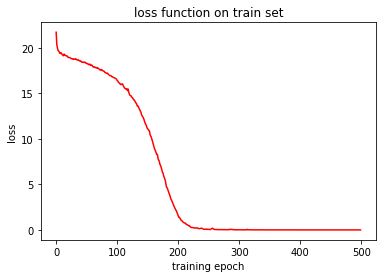

In [12]:
plt.figure(1)
ptr,=plt.plot(range(len(loss_his_train)),loss_his_train,'r-')
plt.xlabel('training epoch')
plt.ylabel('loss')
plt.title('loss function on train set')
# plt.legend((ptr),('train'))
plt.savefig('model-l.png')
plt.show()

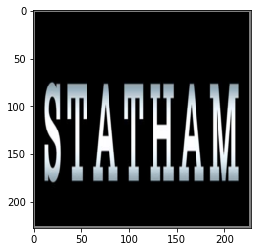

STATHAM
(1, 256, 28, 28)


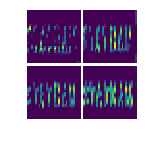

CA-------AT--T----A--------N
Variable containing:
(0 ,.,.) = 
 -10.8513 -16.1091 -18.8602  ...  -21.8342 -18.6800 -12.9218

(1 ,.,.) = 
  -9.9189  -8.0930 -23.3184  ...  -20.4807 -17.5868 -14.2532

(2 ,.,.) = 
   6.8067  -9.0525 -22.6155  ...  -23.5990 -21.4723 -21.9088
...

(25,.,.) = 
  15.7213 -25.4378 -23.5532  ...  -26.7619 -29.3804 -26.0793

(26,.,.) = 
   0.6912 -23.3842 -24.7900  ...  -24.4646 -24.7184 -23.3632

(27,.,.) = 
 -13.1913 -20.4634 -19.7307  ...  -13.7321 -13.9982 -19.2099
[torch.cuda.FloatTensor of size 28x1x63 (GPU 0)]

Variable containing:
 45
 46
 27
 46
 34
 27
 39
[torch.IntTensor of size 7]

31.05719566345215


In [13]:
dataiter = iter(loader_test)
image_test, label_test = dataiter.next()

imshow(utils.make_grid(image_test))
print(label_test[0])

x_var_test = Variable(image_test.type(dtype))
out=my_model.feature_extractor(x_var_test)
feature_map=out.cpu().data.numpy()
print(feature_map.shape)
sample_index=np.random.choice(256,4)
plt.figure(figsize = (2,2))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(4):
    plt.subplot(gs1[i])
    feature_submap=feature_map[0,sample_index[i],:,:]
    plt.imshow(feature_submap)
    plt.axis('off')
plt.show()

my_model.RNN.init_hidden(1)
result=my_model(x_var_test)
result_np=result.cpu().data.numpy()
result_word=''
for i in range(sequence_len):
    ch=np.argmax(result_np[i,0,:])
    result_word+=indexTochr[ch]
print(result_word)

out_size=Variable(torch.IntTensor([sequence_len]))
y_size=Variable(torch.IntTensor([len(l) for l in label_test]))
conc_label=''.join(label_test)
y=[chrToindex[c] for c in conc_label]
y_var=Variable(torch.IntTensor(y))
loss=loss_function(result,y_var,out_size,y_size)
print(result)
print(y_var)
print(loss.data[0])

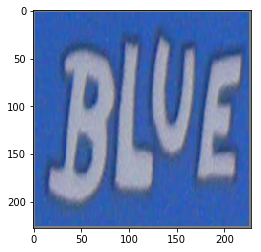

BLUE
(1, 256, 28, 28)


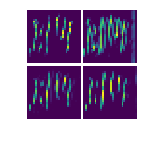

BL-----------------U-------E
Variable containing:
(0 ,.,.) = 
  1.9025e-05  5.3981e-10  3.2020e-10  ...   1.2474e-07  1.2866e-09  6.9224e-14

(1 ,.,.) = 
  4.4727e-11  1.6166e-07  1.4034e-09  ...   1.5364e-04  6.2958e-06  5.9636e-10

(2 ,.,.) = 
  1.0000e+00  1.4138e-12  4.0035e-15  ...   6.5331e-15  2.7044e-12  7.8553e-18
...

(25,.,.) = 
  1.0000e+00  2.4151e-19  1.2929e-18  ...   1.1478e-18  5.4565e-22  3.0796e-23

(26,.,.) = 
  1.0000e+00  3.0220e-14  5.9766e-14  ...   1.6287e-14  1.3199e-13  7.4818e-15

(27,.,.) = 
  9.2875e-05  1.6612e-07  3.0847e-07  ...   2.5702e-07  2.3220e-07  3.1878e-07
[torch.cuda.FloatTensor of size 28x1x63 (GPU 0)]

Variable containing:
 28
 38
 47
 31
[torch.IntTensor of size 4]

21.574623107910156


In [14]:
dataiter = iter(loader_train)
image_train, label_train = dataiter.next()
image_train=image_train[0,...].resize_([1]+list(image_train.size())[1:])

imshow(utils.make_grid(image_train))
print(label_train[0])

x_var_train = Variable(image_train.type(dtype))
out=my_model.feature_extractor(x_var_train)
feature_map=out.cpu().data.numpy()
print(feature_map.shape)
sample_index=np.random.choice(256,4)
plt.figure(figsize = (2,2))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(4):
    plt.subplot(gs1[i])
    feature_submap=feature_map[0,sample_index[i],:,:]
    plt.imshow(feature_submap)
    plt.axis('off')
plt.show()

my_model.RNN.init_hidden(1)
result=my_model(x_var_train)
softmax=nn.Softmax(dim=2)
result_sf=softmax(result)
result_np=result.cpu().data.numpy()
result_word=''
for i in range(sequence_len):
    ch=np.argmax(result_np[i,0,:])
    result_word+=indexTochr[ch]
print(result_word)

out_size=Variable(torch.IntTensor([sequence_len]))
y_size=Variable(torch.IntTensor([len(l) for l in label_train[0]]))
conc_label=''.join(label_train[0])
y=[chrToindex[c] for c in conc_label]
y_var=Variable(torch.IntTensor(y))
loss=loss_function(result,y_var,out_size,y_size)
print(result_sf)
print(y_var)
print(loss.data[0])